# Proof-of-concept demo: CONUS scale hydrologic model results; discover and retrieve using NLDI
* demo uses siphon to search existing thredds catalog of onhm ouput (note this is still very experimental).  
* seg_outflow is assigned to a variable
* Search NLDI for NHM POI.  POIs provide the cross-walk between the specific model fabric, and the common NHD+ fabric.
* NLDI is searched for all gages and streamsegments upstream of gage 09112500  EAST RIVER AT ALMONT, CO.
* Example comparison is given for observed and simulated streamflow 


In [1]:
import py3dep
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import dataretrieval.nwis as nwis
from siphon.catalog import TDSCatalog

In [2]:
# Current test location of NHM ouput
# catalog = TDSCatalog("http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/catalog/ONHM_OUTPUT/files/catalog.xml")
catalog = TDSCatalog("https://cida.usgs.gov/thredds/catalog/demo/thredds/nhm/catalog.xml")

In [3]:
print("\n".join(catalog.datasets.keys()))

seg_outflow.nc
nhm1_seg.ncml


In [4]:
dataset = 'seg_outflow.nc'
ds = catalog.datasets[dataset]
print(ds.name, ds.url_path, ds.access_urls, type(ds))

seg_outflow.nc demo/thredds/nhm/seg_outflow.nc {'OPENDAP': 'https://cida.usgs.gov/thredds/dodsC/demo/thredds/nhm/seg_outflow.nc', 'NetcdfSubset': 'https://cida.usgs.gov/thredds/ncss/demo/thredds/nhm/seg_outflow.nc', 'HTTPServer': 'https://cida.usgs.gov/thredds/fileServer/demo/thredds/nhm/seg_outflow.nc'} <class 'siphon.catalog.Dataset'>


In [5]:
data = ds.remote_access(service='OPENDAP', use_xarray=True)

In [6]:
data.seg_outflow.attrs

{'long_name': 'Streamflow leaving a segment',
 'units': 'cfs',
 '_ChunkSizes': array([ 46, 178])}

In [7]:
data

<xarray.Dataset>
Dimensions:      (nsegment: 58489, time: 14975)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * nsegment     (nsegment) int32 1 2 3 4 5 6 ... 58485 58486 58487 58488 58489
Data variables:
    nhm_seg      (nsegment) int32 ...
    seg_outflow  (time, nsegment) float32 ...
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  time

## Connect NHM Model ouput on THREDDS with NLDI.
* use GFv11 POI interest, which contains NHD comid for each stream segment.
* GFv11 POIs made available to NLDI through geoconnex

## Use hyriver python tools which have a nice wrapper around NLDI and NWIS
* https://hyriver.readthedocs.io/en/latest/

In [8]:
import hydrodata as hd
from hydrodata import NWIS, plot
from pynhd import NLDI, NHDPlusHR, WaterData

### Search NLDI by navigating above USGS-09112500 EAST RIVER AT ALMONT, CO
* grab all comids and gages on main flowline.  
* Use station comids to filter NHM POIs
<!-- ![East River](NLDI_Gage_image.jpg) -->

In [9]:
gage_id = '09112500'
nldi_flw_main = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="flowlines",
                             distance=50)

nldi_st_all = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="nwissite",
                             distance=50)

nldi_POI_all = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="gfv11_pois",
                             distance=50)

In [10]:
nldi_flw_main.head()

,geometry,nhdplus_comid
0,"LINESTRING (-106.85461 38.67733, -106.85455 38...",1333418
1,"LINESTRING (-106.85759 38.69055, -106.85741 38...",1333402
2,"LINESTRING (-106.85145 38.70254, -106.85148 38...",1333386
3,"LINESTRING (-106.85075 38.70790, -106.85069 38...",1333374
4,"LINESTRING (-106.85069 38.71094, -106.85075 38...",1333362


In [11]:
nldi_st_all.head()

,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
0,POINT (-106.95600 38.92717),nwissite,NWIS Sites,USGS-385538106572201,"Y0955 EAST RV AT SEEP T123, BLW GOTHIC",https://waterdata.usgs.gov/monitoring-location...,1332754,14020001000115,34.4832761519,https://labs.waterdata.usgs.gov/api/nldi/linke...
1,POINT (-106.95362 38.92327),nwissite,NWIS Sites,USGS-385524106571401,"EAST RIVER AT UNAMED TRIB, ABV PUMP HOUSE, MCB",https://waterdata.usgs.gov/monitoring-location...,1332754,14020001000115,25.3877567152,https://labs.waterdata.usgs.gov/api/nldi/linke...
2,POINT (-106.96671 38.93582),nwissite,NWIS Sites,USGS-385609106575800,EAST RIVER BELOW GOTHIC,https://waterdata.usgs.gov/monitoring-location...,1332754,14020001000115,60.0175452656,https://labs.waterdata.usgs.gov/api/nldi/linke...
3,POINT (-106.95639 38.92694),nwissite,NWIS Sites,USGS-385537106572301,"SW03 UNAMED BEAVER POND 2 W OF EAST RIVER, GOTHIC",https://waterdata.usgs.gov/monitoring-location...,1332754,14020001000115,34.4832761519,https://labs.waterdata.usgs.gov/api/nldi/linke...
4,POINT (-106.85143 38.71610),nwissite,NWIS Sites,USGS-384258106510300,"EAST R AT ROARING JUDY HATCHERY NEAR ALMONT, CO",https://waterdata.usgs.gov/monitoring-location...,1333344,14020001000461,56.6094443410,https://labs.waterdata.usgs.gov/api/nldi/linke...


In [12]:
nldi_POI_all

,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
0,POINT (-106.87287 38.77568),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,42953,East River,https://geoconnex.us/usgs/gfv11_pois/42953,1333208,14020001000462,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...
1,POINT (-106.84702 38.66359),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,42954,East River,https://geoconnex.us/usgs/gfv11_pois/42954,1333418,14020001000448,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...
2,POINT (-106.90841 38.88061),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,42949,East River,https://geoconnex.us/usgs/gfv11_pois/42949,1332888,14020001000112,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...


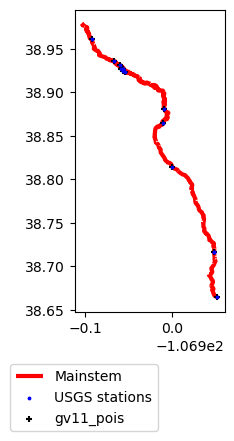

In [13]:
ax = nldi_flw_main.plot(
    lw=3, color="r", zorder=2, label="Mainstem"
)
nldi_st_all.plot(
    ax = ax, label="USGS stations", marker="o", markersize=3, zorder=4, color="b"
)
nldi_st_all.plot(
    ax = ax, label="gv11_pois", marker="+", markersize=24, zorder=3, color="black"
)
ax.legend(bbox_to_anchor=(0.6, -0.15))
ax.set_aspect("equal")
ax.figure.set_dpi(100)

In [14]:
# Get comid for gage of interest USGS-09112500
st = nldi_st_all.loc[nldi_st_all['identifier'] == 'USGS-09112500']
st_comid = st['comid'].values[0]
print(st['comid'].values[0])

1333418


In [15]:
# find identifier in nldi_POI_all that has comid = gage of interest
poi = nldi_POI_all.loc[nldi_POI_all['comid'] == st_comid]
# NHM stream segment is the identifier in poi
nhm_seg_id = int(poi['identifier'].values[0])
print(nhm_seg_id)

42954


## Plot segment outflow for nhm_seg_id by selecting the segment in data returned from THREDDS

In [16]:
nhm_seg_ouflow = data.isel(nsegment=nhm_seg_id)
nhm_seg_ouflow_cms = nhm_seg_ouflow.seg_outflow * 0.02381

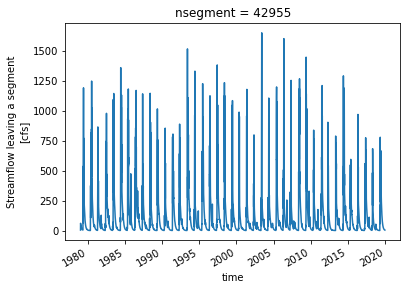

In [17]:
ax = nhm_seg_ouflow.seg_outflow.plot()

### Retrieve NWIS data and plot comparison of measured and simulated flow at gage of interest
* hydrodata NWIS package (NWIS)


In [18]:
from hydrodata import NWIS
site='09112500'
qobs = NWIS().get_streamflow(site, ("1980-01-01", "2007-12-31"))

# Comparison of observed vs simulated

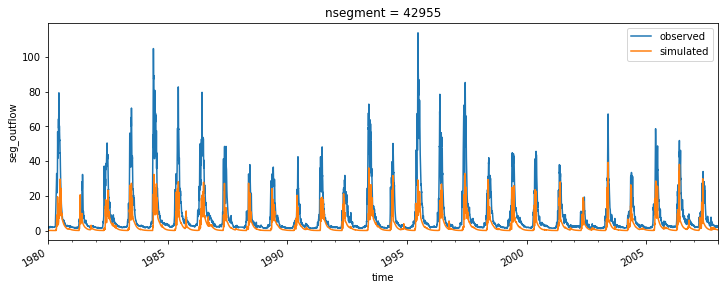

In [19]:
fig, axs = plt.subplots(figsize=(12, 4))
qobs['USGS-09112500'].plot(ax=axs, label="observed")
nhm_seg_ouflow_cms.plot(ax=axs, label="simulated")
axs.legend()